<a href="https://colab.research.google.com/github/TamarSdeChen/Self-Learner-DeepLearning-Course-Technion/blob/main/baseline_accuracy_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libareies
import time
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torchvision.datasets import STL10
from torchvision import transforms, utils, models
from torchvision.transforms import ToTensor


In [ ]:
#download the labeled train and test dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with vlaues [0, 1]
])

TRAIN_DATASET = STL10(root="data", split="train", download=True, transform=transform_train)
TEST_DATASET = STL10(root="data", split="test", download=True, transform=ToTensor())

#create dataloader
train_loader = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=128, shuffle=True, num_workers=2)
tset_loader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=128,  shuffle=False, num_workers=2)

#define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn of DropOut, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy

In [ ]:
model =  models.resnet18().to(device)

In [ ]:
#create a new class for the FC layers to transform the output vector of the ResNet18 to a vector of 10
class fc_model(nn.Module):
    def __init__(self):
        super(fc_model, self).__init__()
        self.fc_1 = nn.Linear(512, 128)
        self.fc_2 = nn.Linear(128,10)
        self.ReLU = nn.ReLU()
        self.init_weights()

    def init_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          torch.nn.init.xavier_normal_(m.weight, gain=1.0)
          if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.ReLU(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [ ]:
#create a new instance of the FC model and implement it to the ResNet18
model_ = fc_model().to(device)
model.fc = model_

In [ ]:
#train all the parameters of the model
for param in model.parameters():
        param.requires_grad = True
for param in model.fc.parameters():
        param.requires_grad = True

In [ ]:
# hyper parameter
batch_size = 256
learning_rate = 1e-3
epochs = 200

# loss criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.5)

In [ ]:
# training loop
epoch_losses = []
acc_train_list = []
avg_loss_list = []
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode, turn on DropOut, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels.to(torch.int64))  # calculate the loss

        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    #scheduler.step()
    # Normalizing the loss by the total number of train batches
    avg_loss = running_loss / len(train_loader)
    avg_loss_list.append(avg_loss)

    log = "Epoch: {} | Loss: {:.4f} ".format(epoch, avg_loss)
    print(log)
print('==> Finished Training ...')

Epoch: 1 | Loss: 2.0340 
Epoch: 2 | Loss: 1.8055 
Epoch: 3 | Loss: 1.7336 
Epoch: 4 | Loss: 1.6540 
Epoch: 5 | Loss: 1.6518 
Epoch: 6 | Loss: 1.5632 
Epoch: 7 | Loss: 1.5829 
Epoch: 8 | Loss: 1.5606 
Epoch: 9 | Loss: 1.4984 
Epoch: 10 | Loss: 1.4178 
Epoch: 11 | Loss: 1.3987 
Epoch: 12 | Loss: 1.4151 
Epoch: 13 | Loss: 1.4095 
Epoch: 14 | Loss: 1.3369 
Epoch: 15 | Loss: 1.3458 
Epoch: 16 | Loss: 1.2987 
Epoch: 17 | Loss: 1.3329 
Epoch: 18 | Loss: 1.2454 
Epoch: 19 | Loss: 1.2363 
Epoch: 20 | Loss: 1.2720 
Epoch: 21 | Loss: 1.2327 
Epoch: 22 | Loss: 1.1765 
Epoch: 23 | Loss: 1.2171 
Epoch: 24 | Loss: 1.2646 
Epoch: 25 | Loss: 1.2111 
Epoch: 26 | Loss: 1.1948 
Epoch: 27 | Loss: 1.1547 
Epoch: 28 | Loss: 1.1230 
Epoch: 29 | Loss: 1.1090 
Epoch: 30 | Loss: 1.1139 
Epoch: 31 | Loss: 1.0875 
Epoch: 32 | Loss: 1.0536 
Epoch: 33 | Loss: 1.0700 
Epoch: 34 | Loss: 1.0784 
Epoch: 35 | Loss: 1.0324 
Epoch: 36 | Loss: 1.0784 
Epoch: 37 | Loss: 1.0513 
Epoch: 38 | Loss: 1.0011 
Epoch: 39 | Loss: 1.0

In [ ]:
test_accuracy = calculate_accuracy(model, tset_loader, device)
print(f"final test accuracy: {test_accuracy}")

final test accuracy: 73.5375


<function matplotlib.pyplot.show(close=None, block=None)>

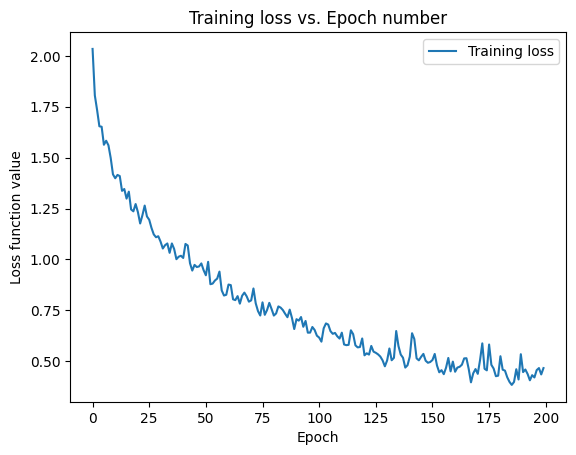

In [ ]:
epoch_num = np.arange(0, 200, 1, dtype=int)
plt.plot(epoch_num, torch.as_tensor(avg_loss_list).cpu(), label='Training loss')
plt.ylabel('Loss function value')
plt.xlabel('Epoch')
plt.title('Training loss vs. Epoch number')
plt.legend()
#save the figure
plt.show

In [ ]:
print('==> Saving model ...')
state = {
'net': model.state_dict(),
}

torch.save(state, 'baseline_resnet18.pth')

==> Saving model ...
